In [1]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, DQN

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import sympy as sp
import pickle

## Mathematical system description with SymPy / symbtools

In [2]:
Np = 1 # number of passive coordinates (p = phi1)
Nq = 1 # number of actuated coordinates (q = x0)
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))

# all coordinates and their derivatives
ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

F = sp.Symbol('F')

params = sp.symbols('m0, m1, l1, g, d0, d1')
st.make_global(params)
params_values = [(m0, 1.0), (m1, 0.1), (l1, 0.5), (g, 9.81),
                 (d0, 0.01), (d1, 0.01)]

In [3]:
# load model etc. from pickle of flatness analysis notebook
with open("../single_crane_notebooks/model_single_crane.pcl", "rb") as pfile:
    mod = pickle.load(pfile) # mod instead of data
    #locals().update(data)

In [4]:
mod.xx

Matrix([
[   p1],
[   q1],
[pdot1],
[qdot1]])

In [5]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[            d0*pdot1 + g*l1*m1*sin(p1) + l1**2*m1*pddot1 - l1*m1*qddot1*cos(p1)],
[-Fcomp + 1.0*m0*qddot1 + m1*(-l1*pddot1*cos(p1) + l1*pdot1**2*sin(p1) + qddot1)]])

In [6]:
states_dot = mod.f + mod.g * F

In [7]:
states_dot_wo_params = states_dot.subs(params_values)

In [8]:
states_dot_func = st.expr_to_func([*mod.xx, F], states_dot_wo_params)

## Gym environment

In [104]:
import math
from typing import Optional, Union

import numpy as np

import gym
from gym import logger, spaces
#from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
#from gym.utils.renderer import Renderer

class StateSpaceModel(gym.Env):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        o
        o_
        oDim
    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=0.):
        self.tt = [0]
        self.dt = dt
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.uDim = uDim # inputs
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
            
        self.terminated = False
        self.terminal_cost = terminal_cost
    
    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        
        # todo: place difference for desired value with function or smth here
        self.o =  np.array(self.x, dtype=np.float32)
        reward = -c
        return self.o, reward, self.terminated, {"info": False}
    
    @abstractmethod
    def terminate(self, *args):
        return



class CartPoleEnv(StateSpaceModel):

    metadata = {}

    def __init__(self, cost, x0, dt):
        super(CartPoleEnv, self).__init__(self.ode, cost, x0, 1, dt)

        # define observation space
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        # define action space
        high_act = np.array(
            [ 
                100.0
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
    
    @staticmethod
    def ode(t, x, u):
        dxdt = states_dot_func(*x, u)
        return np.array(dxdt, dtype=np.float32)
    
    def terminate(self, x):
        x1, x2, x3, x4 = x
        if abs(x3) > 20 or abs(x2) > 100 or abs(x1) > 8*np.pi:
            return True
        else:
            return False

## Cost function, Initial values

In [105]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4 = x
    u1, = u
    c = x1**2 + x2**2 + 0.1*x3**2 + 0.05*u1**2
    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [np.random.uniform(-0.001,0.001), 5+np.random.uniform(-0.001,0.001), np.random.uniform(-0.001,0.001), np.random.uniform(-0.001,0.001)]
    return x0

t = 10 # time of an episode
dt = 0.05 # time step-size
learning_steps = 1e5 # define training duration

## Create Gym env

In [106]:
# environment without renderings for training
env = CartPoleEnv(c_k, p_x0, dt)

In [107]:
env.reset()
env.step(env.action_space.sample())
env.observation_space
check_env(env)

/home/kwrede/.local/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## Learning the model

In [108]:
%%time
# Learning!
model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/")
model.learn(total_timesteps=learning_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./a2c_cartpole_tensorboard/A2C_42
------------------------------------
| time/                 |          |
|    fps                | 840      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | -0.00223 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -26.8    |
|    std                | 1.01     |
|    value_loss         | 394      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 847       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.43     |
| 

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 6.22e+03  |
|    ep_rew_mean        | -5.35e+05 |
| time/                 |           |
|    fps                | 857       |
|    iterations         | 1500      |
|    time_elapsed       | 8         |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -1.44     |
|    explained_variance | 6.73e-05  |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | -184      |
|    std                | 1.02      |
|    value_loss         | 2.04e+04  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 6.22e+03  |
|    ep_rew_mean        | -5.35e+05 |
| time/                 |           |
|    fps                | 857       |
|    iterations         | 1600      |
|    time_elapsed       | 9         |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.85e+03  |
|    ep_rew_mean        | -2.53e+05 |
| time/                 |           |
|    fps                | 858       |
|    iterations         | 2700      |
|    time_elapsed       | 15        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -1.47     |
|    explained_variance | 2.09e-06  |
|    learning_rate      | 0.0007    |
|    n_updates          | 2699      |
|    policy_loss        | -587      |
|    std                | 1.05      |
|    value_loss         | 1.72e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.85e+03  |
|    ep_rew_mean        | -2.53e+05 |
| time/                 |           |
|    fps                | 858       |
|    iterations         | 2800      |
|    time_elapsed       | 16        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 865       |
|    iterations         | 3900      |
|    time_elapsed       | 22        |
|    total_timesteps    | 19500     |
| train/                |           |
|    entropy_loss       | -1.52     |
|    explained_variance | -0.0151   |
|    learning_rate      | 0.0007    |
|    n_updates          | 3899      |
|    policy_loss        | -6.74     |
|    std                | 1.11      |
|    value_loss         | 33.9      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 866       |
|    iterations         | 4000      |
|    time_elapsed       | 23        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 865       |
|    iterations         | 5100      |
|    time_elapsed       | 29        |
|    total_timesteps    | 25500     |
| train/                |           |
|    entropy_loss       | -1.52     |
|    explained_variance | 0.272     |
|    learning_rate      | 0.0007    |
|    n_updates          | 5099      |
|    policy_loss        | -4.72     |
|    std                | 1.11      |
|    value_loss         | 17.6      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 865       |
|    iterations         | 5200      |
|    time_elapsed       | 30        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 866       |
|    iterations         | 6300      |
|    time_elapsed       | 36        |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -1.54     |
|    explained_variance | 0.000199  |
|    learning_rate      | 0.0007    |
|    n_updates          | 6299      |
|    policy_loss        | -56.6     |
|    std                | 1.13      |
|    value_loss         | 1.3e+03   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 866       |
|    iterations         | 6400      |
|    time_elapsed       | 36        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 871       |
|    iterations         | 7500      |
|    time_elapsed       | 43        |
|    total_timesteps    | 37500     |
| train/                |           |
|    entropy_loss       | -1.67     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 7499      |
|    policy_loss        | -15.4     |
|    std                | 1.28      |
|    value_loss         | 110       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3e+03     |
|    ep_rew_mean        | -3.18e+05 |
| time/                 |           |
|    fps                | 872       |
|    iterations         | 7600      |
|    time_elapsed       | 43        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 5.95e+03  |
|    ep_rew_mean        | -3.49e+05 |
| time/                 |           |
|    fps                | 874       |
|    iterations         | 8700      |
|    time_elapsed       | 49        |
|    total_timesteps    | 43500     |
| train/                |           |
|    entropy_loss       | -1.76     |
|    explained_variance | -1.85     |
|    learning_rate      | 0.0007    |
|    n_updates          | 8699      |
|    policy_loss        | 4.48      |
|    std                | 1.41      |
|    value_loss         | 30.5      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 5.95e+03  |
|    ep_rew_mean        | -3.49e+05 |
| time/                 |           |
|    fps                | 874       |
|    iterations         | 8800      |
|    time_elapsed       | 50        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.47e+03  |
|    ep_rew_mean        | -2.64e+05 |
| time/                 |           |
|    fps                | 875       |
|    iterations         | 9900      |
|    time_elapsed       | 56        |
|    total_timesteps    | 49500     |
| train/                |           |
|    entropy_loss       | -1.85     |
|    explained_variance | -22.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 9899      |
|    policy_loss        | 21.2      |
|    std                | 1.54      |
|    value_loss         | 193       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.47e+03  |
|    ep_rew_mean        | -2.64e+05 |
| time/                 |           |
|    fps                | 875       |
|    iterations         | 10000     |
|    time_elapsed       | 57        |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.19e+03 |
|    ep_rew_mean        | -1.9e+05 |
| time/                 |          |
|    fps                | 875      |
|    iterations         | 11200    |
|    time_elapsed       | 63       |
|    total_timesteps    | 56000    |
| train/                |          |
|    entropy_loss       | -1.89    |
|    explained_variance | 0.751    |
|    learning_rate      | 0.0007   |
|    n_updates          | 11199    |
|    policy_loss        | 5.29     |
|    std                | 1.6      |
|    value_loss         | 9.45     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.19e+03 |
|    ep_rew_mean        | -1.9e+05 |
| time/                 |          |
|    fps                | 875      |
|    iterations         | 11300    |
|    time_elapsed       | 64       |
|    total_timesteps    | 56500    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 876       |
|    iterations         | 12500     |
|    time_elapsed       | 71        |
|    total_timesteps    | 62500     |
| train/                |           |
|    entropy_loss       | -1.92     |
|    explained_variance | -37.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 12499     |
|    policy_loss        | -17.2     |
|    std                | 1.65      |
|    value_loss         | 106       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 876       |
|    iterations         | 12600     |
|    time_elapsed       | 71        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 872       |
|    iterations         | 13700     |
|    time_elapsed       | 78        |
|    total_timesteps    | 68500     |
| train/                |           |
|    entropy_loss       | -1.8      |
|    explained_variance | -1.82     |
|    learning_rate      | 0.0007    |
|    n_updates          | 13699     |
|    policy_loss        | 0.118     |
|    std                | 1.47      |
|    value_loss         | 0.00524   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 871       |
|    iterations         | 13800     |
|    time_elapsed       | 79        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 862       |
|    iterations         | 14900     |
|    time_elapsed       | 86        |
|    total_timesteps    | 74500     |
| train/                |           |
|    entropy_loss       | -1.63     |
|    explained_variance | -2.02     |
|    learning_rate      | 0.0007    |
|    n_updates          | 14899     |
|    policy_loss        | 0.00207   |
|    std                | 1.23      |
|    value_loss         | 0.000245  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 861       |
|    iterations         | 15000     |
|    time_elapsed       | 87        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 847       |
|    iterations         | 16100     |
|    time_elapsed       | 95        |
|    total_timesteps    | 80500     |
| train/                |           |
|    entropy_loss       | -1.45     |
|    explained_variance | -76.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 16099     |
|    policy_loss        | 0.337     |
|    std                | 1.03      |
|    value_loss         | 0.0268    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 845       |
|    iterations         | 16200     |
|    time_elapsed       | 95        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 835       |
|    iterations         | 17300     |
|    time_elapsed       | 103       |
|    total_timesteps    | 86500     |
| train/                |           |
|    entropy_loss       | -1.19     |
|    explained_variance | -0.258    |
|    learning_rate      | 0.0007    |
|    n_updates          | 17299     |
|    policy_loss        | 0.0123    |
|    std                | 0.798     |
|    value_loss         | 0.000282  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 835       |
|    iterations         | 17400     |
|    time_elapsed       | 104       |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 825       |
|    iterations         | 18500     |
|    time_elapsed       | 112       |
|    total_timesteps    | 92500     |
| train/                |           |
|    entropy_loss       | -1        |
|    explained_variance | -5.08     |
|    learning_rate      | 0.0007    |
|    n_updates          | 18499     |
|    policy_loss        | -0.000307 |
|    std                | 0.66      |
|    value_loss         | 7.26e-06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 825       |
|    iterations         | 18600     |
|    time_elapsed       | 112       |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 812       |
|    iterations         | 19700     |
|    time_elapsed       | 121       |
|    total_timesteps    | 98500     |
| train/                |           |
|    entropy_loss       | -0.77     |
|    explained_variance | -0.284    |
|    learning_rate      | 0.0007    |
|    n_updates          | 19699     |
|    policy_loss        | 0.0247    |
|    std                | 0.523     |
|    value_loss         | 0.000835  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.55e+03  |
|    ep_rew_mean        | -1.86e+05 |
| time/                 |           |
|    fps                | 811       |
|    iterations         | 19800     |
|    time_elapsed       | 122       |
|    total_t

## Testing the model

In [109]:
u1_for_plots = []
x1_for_plots = []
x2_for_plots = []
x3_for_plots = []

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action)
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    x3_for_plots = np.append(x3_for_plots, obs[2])
    if done:
      obs = env.reset()
      break;

## Plotting

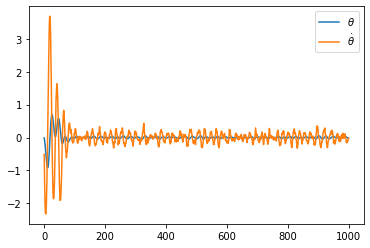

In [110]:
plt.plot(x1_for_plots, label=r"$\theta$")
plt.plot(x3_for_plots, label=r"$\dot{\theta}$")
plt.legend()

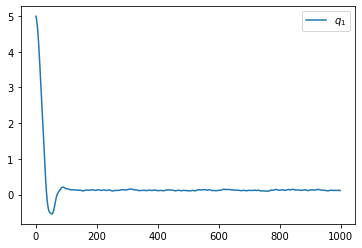

In [111]:
plt.plot(x2_for_plots[:-1], label=r"$q_1$")
plt.legend()

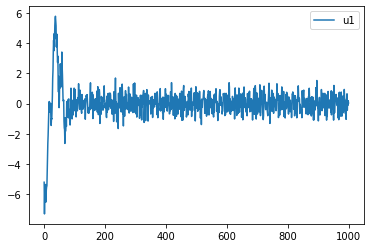

In [112]:
plt.plot(u1_for_plots, label="u1")
plt.legend()